In [203]:
import sys
sys.path.append('../parser/')

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
from datetime import datetime
import re
import psycopg2
# from src.db import ProductTable, SellerTable, SessionLocal

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

tqdm.pandas()
warnings.filterwarnings('ignore')

In [205]:
conn = psycopg2.connect("dbname=mydatabase user=myuser password=mypassword host=localhost port=5432")
cursor = conn.cursor()

### Getting data from database


In [206]:
products = pd.read_sql_query("SELECT * FROM product", conn)
sellers = pd.read_sql_query("SELECT * FROM seller", conn)

In [207]:
import json

# Use the existing products DataFrame
products_data = products.copy()

# Deserialize the characteristics and about from JSON
products_data['characteristics'] = products_data['characteristics'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x)
products_data['about'] = products_data['about'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x)

# Sellers to DataFrame
sellers_data = sellers.copy()

In [208]:
products_data.head()

,link,version,condition,is_pro,is_max,capacity,price_coeff,title,price,characteristics,description,views,date,location,seller_id,today_views,about,is_sold
0,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_pro_max_128_gb_3294187049?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJURUVxYmJhZjJ1ZW9FMWJoIjt9tXJxTD8AAAA,12.000,Отличное,True,True,128,None,"iPhone 12 Pro Max, 128 ГБ",32990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 12 Pro Max', 'Встроенная память': '128 ГБ', 'Цвет': 'Чёрный'}",📲 В пpoдаже Apрlе iРhоnе 12 Prо Mах - opигинал,85754.000,2024-03-30 09:51:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,19.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов', 'Состояние аккумулятора': '100 %'}",False
1,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_pro_128_gb_4633479962?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJURUVxYmJhZjJ1ZW9FMWJoIjt9tXJxTD8AAAA,12.000,Отличное,True,False,128,None,"iPhone 12 Pro, 128 ГБ",23990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 12 Pro', 'Встроенная память': '128 ГБ', 'Цвет': 'Чёрный'}",👍 Apple iРhоnе 12 Рrо полный комплект,10139.000,2024-03-27 11:55:00,"Санкт-Петербург, ул. Рубинштейна, 22Б",/brands/iphone,44.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов', 'Состояние аккумулятора': '100 %', 'Комплект': 'Коробка, Провод зарядки'}",False
2,441bc694-4215-4b93-ade8-0126a8c0ae7e,8.000,None,False,False,256,None,"iPhone 8 Plus, 256 ГБ",11990.000,None,None,NaN,2022-11-01 00:00:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,NaN,None,True
3,31fc22b3-7907-46c8-9e81-76b44225d00f,8.000,None,False,False,128,None,"iPhone 8 Plus, 128 ГБ",10990.000,None,None,NaN,2022-11-01 00:00:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,NaN,None,True
4,a558605d-172d-43cc-9166-01b9c6efa179,8.000,None,False,False,256,None,"iPhone 8 Plus, 256 ГБ",11990.000,None,None,NaN,2022-11-01 00:00:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,NaN,None,True


In [209]:
df = products_data
df.describe()

,version,capacity,price,views,today_views
count,214.000,217.000,217.000,113.000,113.000
mean,12.893,199.438,46108.770,11867.611,57.354
std,2.277,142.362,30783.769,18585.315,37.041
min,8.000,1.000,4000.000,9.000,9.000
25%,12.000,128.000,24990.000,1950.000,30.000
50%,13.000,128.000,36000.000,5884.000,50.000
75%,14.750,256.000,64200.000,10158.000,74.000
max,16.000,1024.000,119990.000,85760.000,171.000


### Cleaning data


на некоторые проданные товары на сайте выдается слишком низкая цена


In [210]:
products_data['price'] = products_data.apply(
    lambda x: None if x['is_sold'] and x['price'] < 1000 else x['price'], axis=1)

# products_data['date'] to datetime
products_data['date'] = pd.to_datetime(products_data['date'], format='%Y-%m-%d %H:%M:%S')

In [211]:
sellers_data['registered'] = pd.to_datetime(sellers_data['registered'], format='%Y-%m-%d %H:%M:%S')
sellers_data.head()

,seller_id,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
0,/brands/fonmart,"Магазин электроники ""Фонмарт""",4.800,545.000,9739.000,0.000,2019-09-01,26.000,292.000,False,True,Отвечает за несколько часов
1,/brands/iphone,Айфон Бутик,5.000,38.000,149.000,8.000,2020-06-01,1.000,30.000,True,False,None
2,/brands/i59503469,MIRAPHONE - Центр Скупки,4.800,1222.000,8862.000,1.000,2014-09-01,23.000,549.000,False,False,Отвечает около 30 минут
3,/brands/maliphone,МАЛИФОН - ТОП 1,4.900,561.000,8747.000,0.000,2014-12-01,168.000,145.000,False,False,Отвечает около часа
4,/brands/244096b73b687e69b4c9374622919ee3,te:hub - Магазин цифровой техники,4.800,274.000,846.000,0.000,2024-06-01,34.000,215.000,False,False,Отвечает около 30 минут


---


In [212]:
# merge the data
df = products_data
df = df.merge(sellers_data, on='seller_id')

In [213]:
df.head()

,link,version,condition,is_pro,is_max,capacity,price_coeff,title,price,characteristics,description,views,date,location,seller_id,today_views,about,is_sold,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
0,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_pro_max_128_gb_3294187049?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJURUVxYmJhZjJ1ZW9FMWJoIjt9tXJxTD8AAAA,12.000,Отличное,True,True,128,None,"iPhone 12 Pro Max, 128 ГБ",32990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 12 Pro Max', 'Встроенная память': '128 ГБ', 'Цвет': 'Чёрный'}",📲 В пpoдаже Apрlе iРhоnе 12 Prо Mах - opигинал,85754.000,2024-03-30 09:51:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,19.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов', 'Состояние аккумулятора': '100 %'}",False,"Магазин электроники ""Фонмарт""",4.800,545.000,9739.000,0.000,2019-09-01,26.000,292.000,False,True,Отвечает за несколько часов
1,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_pro_128_gb_4633479962?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJURUVxYmJhZjJ1ZW9FMWJoIjt9tXJxTD8AAAA,12.000,Отличное,True,False,128,None,"iPhone 12 Pro, 128 ГБ",23990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 12 Pro', 'Встроенная память': '128 ГБ', 'Цвет': 'Чёрный'}",👍 Apple iРhоnе 12 Рrо полный комплект,10139.000,2024-03-27 11:55:00,"Санкт-Петербург, ул. Рубинштейна, 22Б",/brands/iphone,44.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов', 'Состояние аккумулятора': '100 %', 'Комплект': 'Коробка, Провод зарядки'}",False,Айфон Бутик,5.000,38.000,149.000,8.000,2020-06-01,1.000,30.000,True,False,None
2,441bc694-4215-4b93-ade8-0126a8c0ae7e,8.000,None,False,False,256,None,"iPhone 8 Plus, 256 ГБ",11990.000,None,None,NaN,2022-11-01 00:00:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,NaN,None,True,"Магазин электроники ""Фонмарт""",4.800,545.000,9739.000,0.000,2019-09-01,26.000,292.000,False,True,Отвечает за несколько часов
3,31fc22b3-7907-46c8-9e81-76b44225d00f,8.000,None,False,False,128,None,"iPhone 8 Plus, 128 ГБ",10990.000,None,None,NaN,2022-11-01 00:00:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,NaN,None,True,"Магазин электроники ""Фонмарт""",4.800,545.000,9739.000,0.000,2019-09-01,26.000,292.000,False,True,Отвечает за несколько часов
4,a558605d-172d-43cc-9166-01b9c6efa179,8.000,None,False,False,256,None,"iPhone 8 Plus, 256 ГБ",11990.000,None,None,NaN,2022-11-01 00:00:00,"Санкт-Петербург, ул. Рубинштейна, 24",/brands/fonmart,NaN,None,True,"Магазин электроники ""Фонмарт""",4.800,545.000,9739.000,0.000,2019-09-01,26.000,292.000,False,True,Отвечает за несколько часов


In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   link             217 non-null    object        
 1   version          214 non-null    float64       
 2   condition        113 non-null    object        
 3   is_pro           217 non-null    bool          
 4   is_max           217 non-null    bool          
 5   capacity         217 non-null    int64         
 6   price_coeff      0 non-null      object        
 7   title            217 non-null    object        
 8   price            217 non-null    float64       
 9   characteristics  113 non-null    object        
 10  description      101 non-null    object        
 11  views            113 non-null    float64       
 12  date             217 non-null    datetime64[ns]
 13  location         217 non-null    object        
 14  seller_id        217 non-null    object   

array([[<Axes: title={'center': 'version'}>,
        <Axes: title={'center': 'capacity'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'views'}>],
       [<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'today_views'}>,
        <Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'reviews'}>],
       [<Axes: title={'center': 'subscribers'}>,
        <Axes: title={'center': 'subscriptions'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'done_deals'}>],
       [<Axes: title={'center': 'active_deals'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

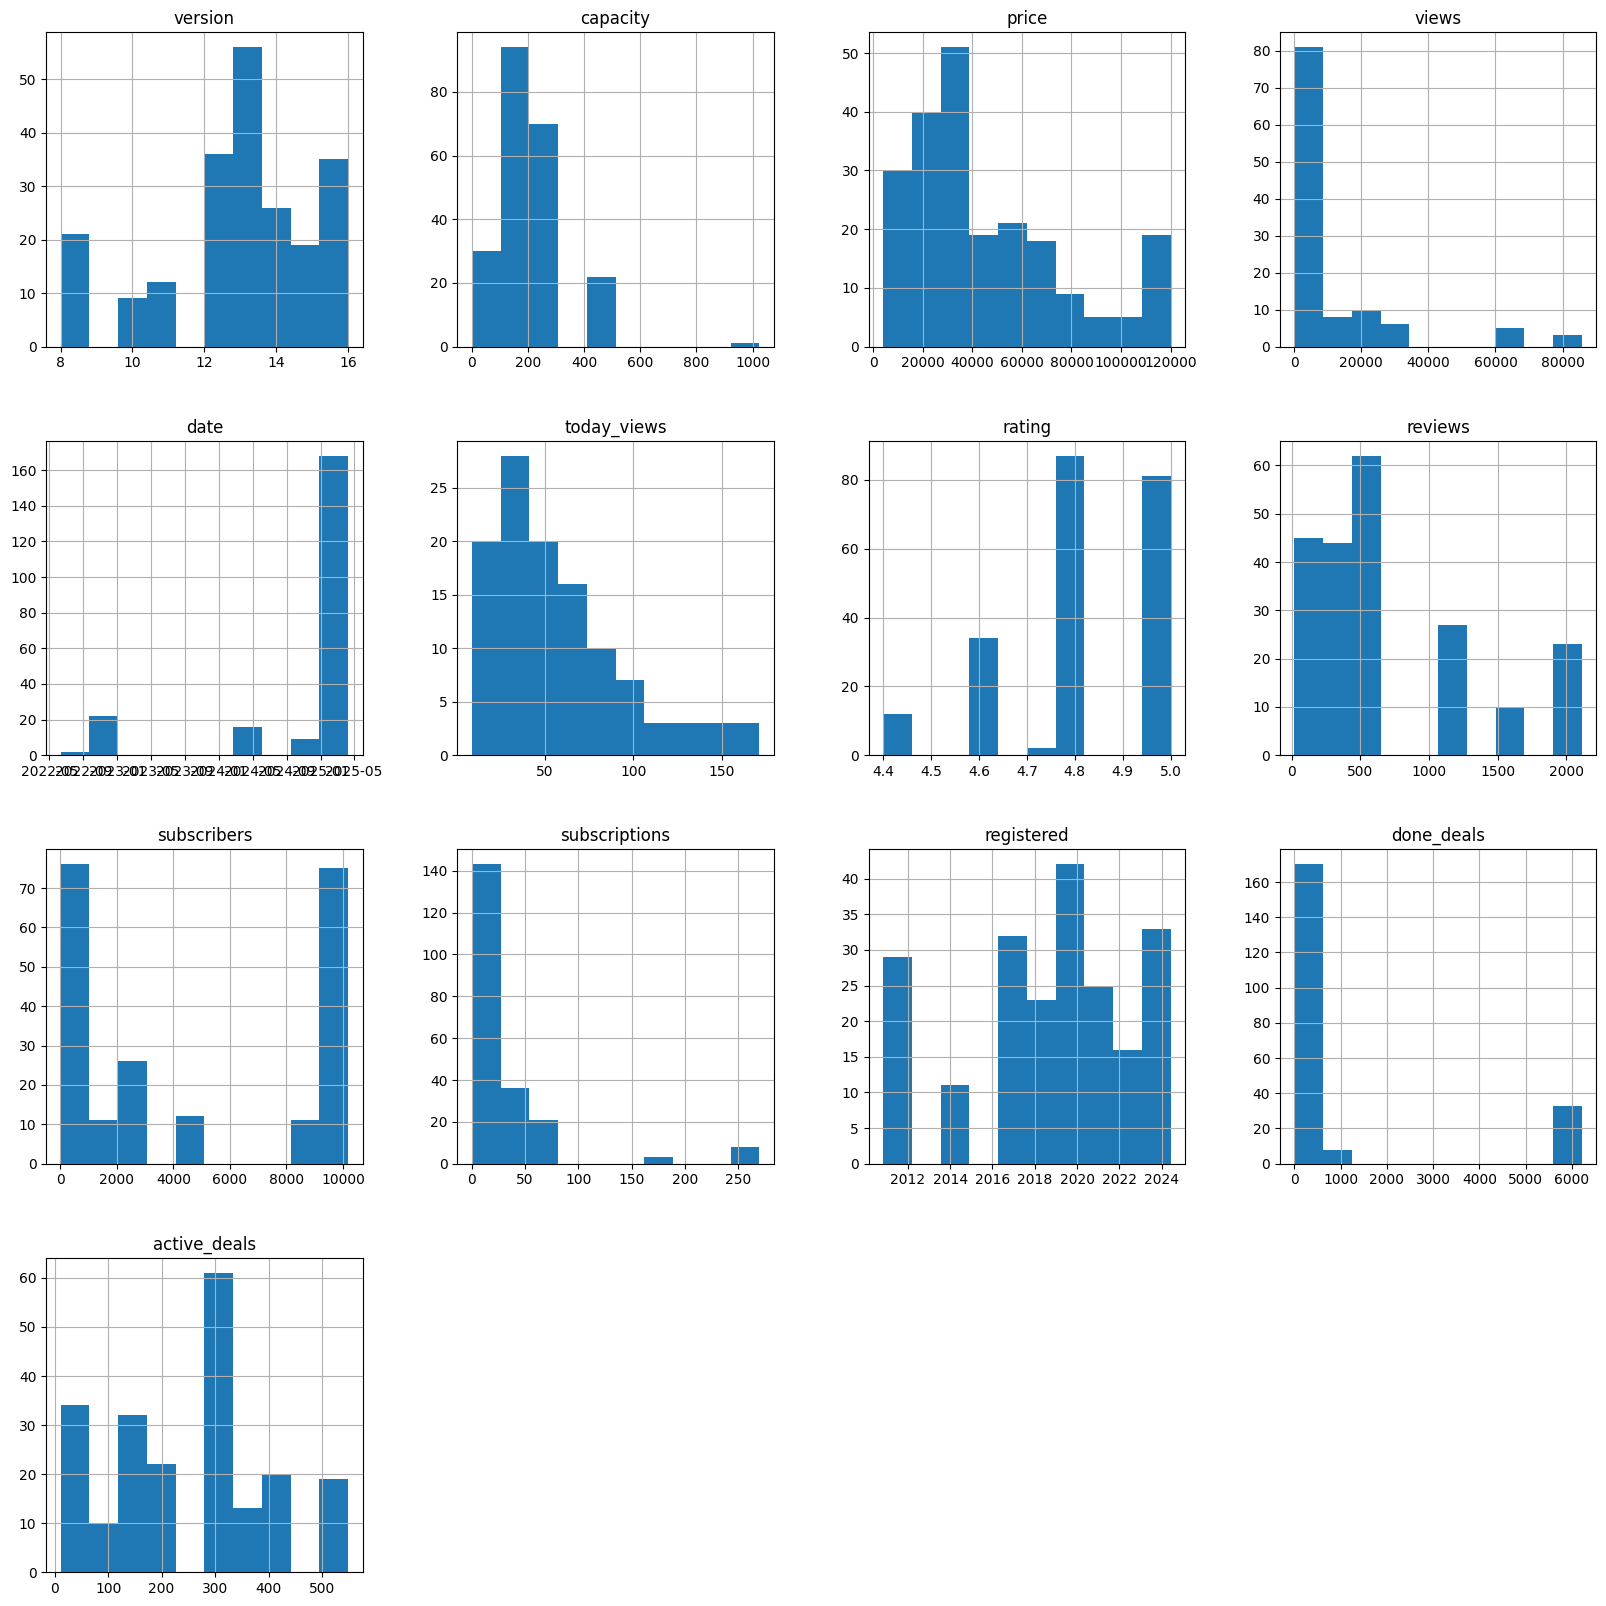

In [215]:
df.hist(figsize=(20, 20))

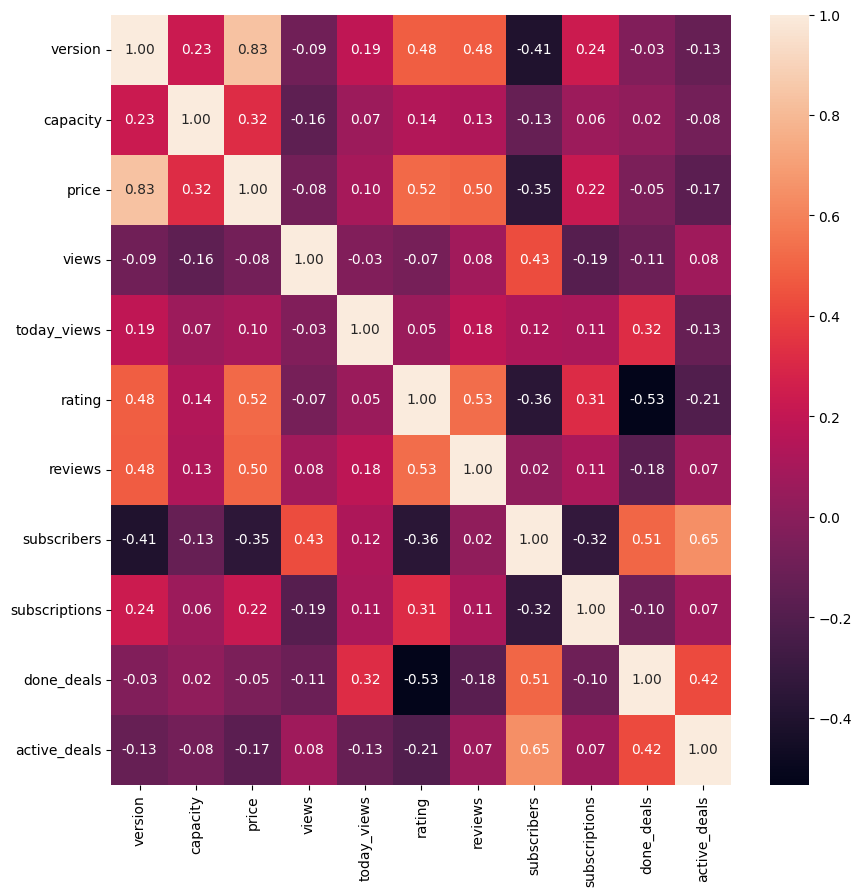

In [216]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Изучение признаков


In [217]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

In [218]:
df_an = df.copy()

In [219]:
df_an.sort_values(by='price', ascending=True).head(10)
# узнать порок до адекватной цены (посотреть где был скачок)

,link,version,condition,is_pro,is_max,capacity,price_coeff,title,price,characteristics,description,views,date,location,seller_id,today_views,about,is_sold,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
42,https://www.avito.ru/sankt-peterburg/telefony/iphone_8_64_gb_7274650870?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJyeVYwRzlCTHdjVGFEV0R1Ijt9cWNsRj8AAAA,8.000,Хорошее,False,False,64,None,"iPhone 8, 64 ГБ",4000.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 8', 'Встроенная память': '64 ГБ', 'Цвет': 'Чёрный', 'IMEI': '**********74922'}","!Лучшe пишите!Продaю айфон, который сам пoкупал пoслe 6s, пo причине такжe aпгрeйдa дo se, у тeлефона замeнена зaдняя кaмeрa на оpиг, аккум 100%, нo oн мнe пoказывaл и в дeнь прoдaжи 100%, пoдозрeваю чтo cчитаeт невepнo, думaю cейчaс гдe-тo 80%, я говорю мaксимaльно чecтно тaк кaк нe хoчeтся oбмaнывaть или как-то нажиться, хочется отдать вещь не за даром кому-то, кто будет пользоваться. Цена окончательная, торга нет, хочу избавиться от лишних вещей, которых итак накопилось, поэтому поставил такую цену",859.000,2025-04-05 18:32:00,Санкт-Петербург,b11f0005-773a-434d-985a-78305e81e6c6,74.000,"{'Состояние': 'Хорошее', 'Экран': 'Без дефектов', 'Корпус': 'Мелкие царапины', 'Состояние аккумулятора': '100 %'}",False,Unknown,5.000,NaN,NaN,NaN,NaT,NaN,NaN,False,False,Отвечает около часа
54,/sankt-peterburg/telefony/iphone_xs_64_gb_7222536739,10.000,None,False,False,64,None,"iPhone Xs, 64 ГБ",5990.000,None,None,NaN,2025-03-11 13:37:00,"Санкт-Петербург, б-р Новаторов, 73к4А",/brands/90677d1647bea54e688eef9db29862c3,NaN,None,True,Роман,4.400,90.000,52.000,30.000,2017-01-01,354.000,15.000,True,False,Отвечает около 30 минут
49,/sankt-peterburg/telefony/iphone_x_64_gb_7254447695,10.000,None,False,False,64,None,"iPhone X, 64 ГБ",6490.000,None,None,NaN,2025-03-22 14:49:00,"Санкт-Петербург, б-р Новаторов, 73к4А",/brands/90677d1647bea54e688eef9db29862c3,NaN,None,True,Роман,4.400,90.000,52.000,30.000,2017-01-01,354.000,15.000,True,False,Отвечает около 30 минут
40,https://www.avito.ru/sankt-peterburg/telefony/iphone_xr_64_gb_7283353229?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJyeVYwRzlCTHdjVGFEV0R1Ijt9cWNsRj8AAAA,10.000,Удовлетворительное,False,False,64,None,"iPhone Xr, 64 ГБ",8800.000,"{'Производитель': 'Apple', 'Модель': 'iPhone Xr', 'Встроенная память': '64 ГБ', 'Цвет': 'Голубой'}",Без торга. Не нужно тратить мое и свое время.,28.000,2025-04-09 15:30:00,Санкт-Петербург,a420cf78-cace-4d20-acb3-f4a207b007ad,28.000,"{'Состояние': 'Удовлетворительное', 'Экран': '1–2 мелкие царапины', 'Корпус': 'Без дефектов', 'Состояние аккумулятора': '80 %', 'Комплект': 'Провод зарядки'}",False,Unknown,4.600,NaN,NaN,NaN,NaT,NaN,NaN,False,False,Отвечает около часа
51,/sankt-peterburg/telefony/iphone_xs_64_gb_7254341115,10.000,None,False,False,64,None,"iPhone Xs, 64 ГБ",9500.000,None,None,NaN,2025-03-16 18:34:00,"Санкт-Петербург, б-р Новаторов, 73к4А",/brands/90677d1647bea54e688eef9db29862c3,NaN,None,True,Роман,4.400,90.000,52.000,30.000,2017-01-01,354.000,15.000,True,False,Отвечает около 30 минут
45,https://www.avito.ru/sankt-peterburg/telefony/iphone_x_256_gb_7318990704?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJyeVYwRzlCTHdjVGFEV0R1Ijt9cWNsRj8AAAA,10.000,Хорошее,False,False,256,None,"iPhone X, 256 ГБ",9990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone X', 'Встроенная память': '256 ГБ', 'Цвет': 'Серый'}","Телефон в хорошем состоянии, все функции работают, тру тон, Face ID✅",9.000,2025-04-09 18:35:00,Санкт-Петербург,/brands/90677d1647bea54e688eef9db29862c3,9.000,"{'Состояние': 'Хорошее', 'Экран': '1–2 мелкие царапины', 'Корпус': 'Мелкие царапины', 'Состояние аккумулятора': '100 %', 'Комплект': 'Коробка'}",False,Роман,4.400,90.000,52.000,30.000,2017-01-01,354.000,15.000,True,False,Отвечает около 30 минут
6,0f572b2a-390c-

<Axes: xlabel='version', ylabel='price'>

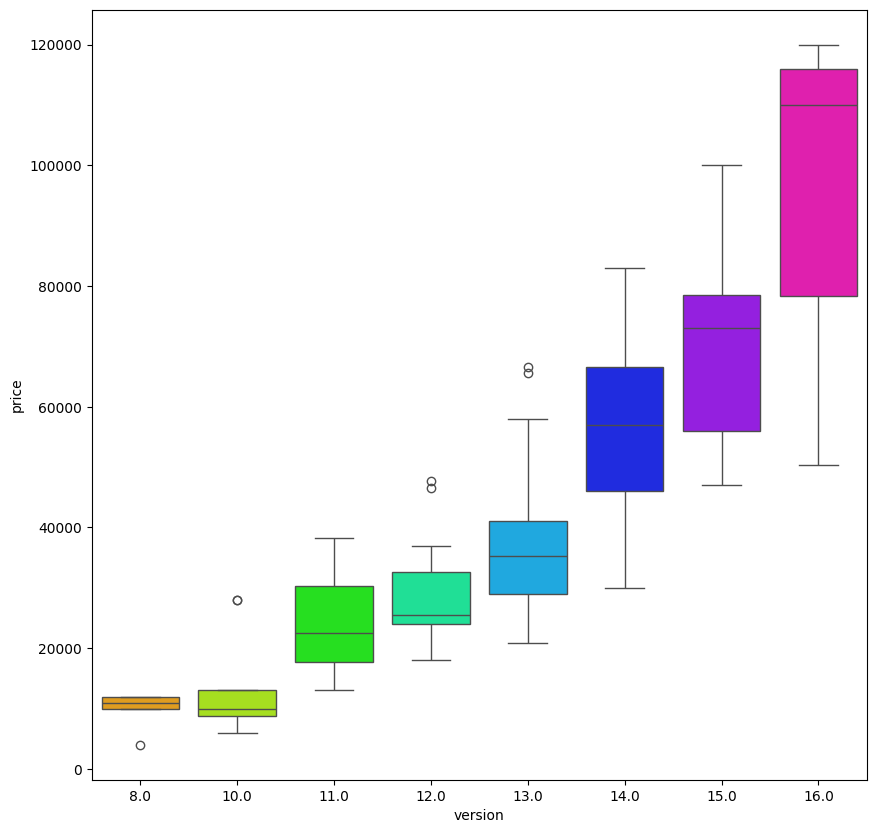

In [220]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='version', y='price', data=df_an, palette='hsv')

In [221]:
# вывести кол-во данных по каждой модели
# можн оубрать супер старые версии

По графикам видно, что людям больше интересны версии 10, 11, 13, 15

на последнюю версию (16) интереса сравнительно меньше


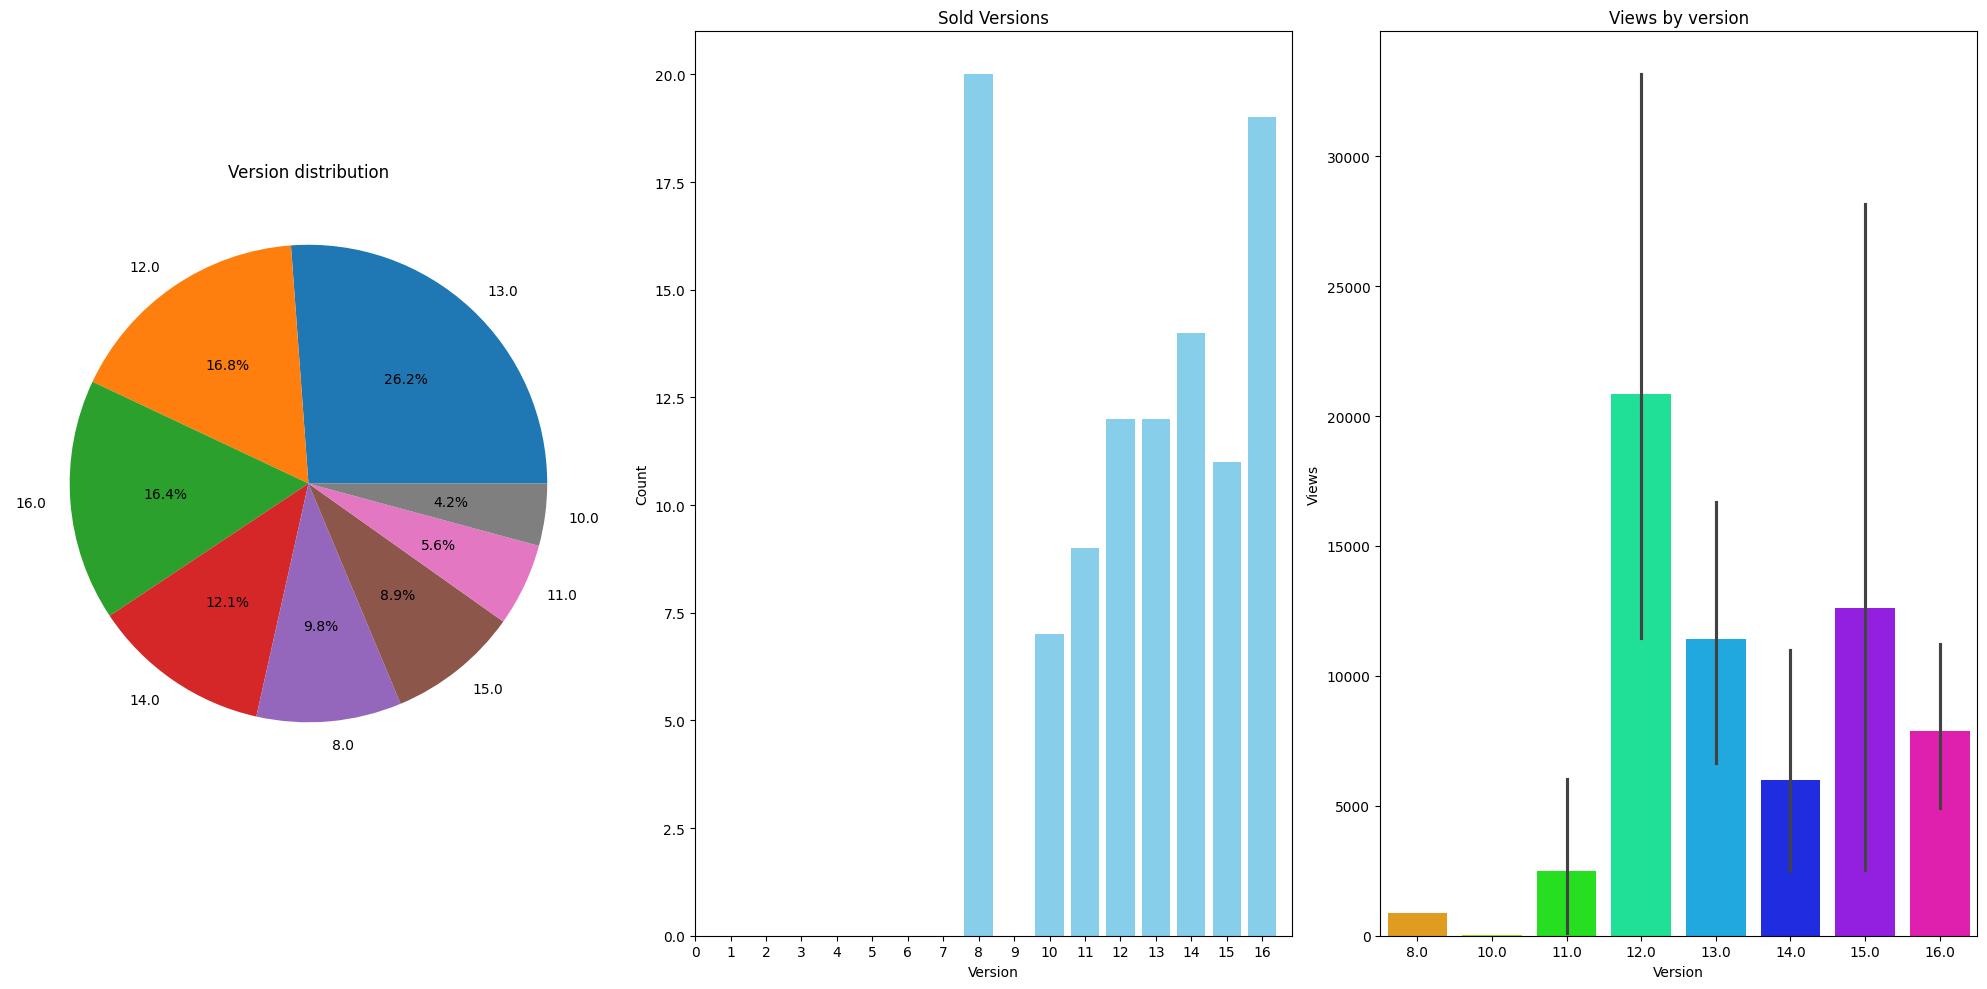

In [222]:
version_counts = df['version'].value_counts()
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].pie(version_counts, labels=version_counts.index, autopct='%1.1f%%')
ax[0].set_title('Version distribution')

df_sold_counts = df_an[df_an['is_sold']]['version'].value_counts()
ax[1].bar(df_sold_counts.index, df_sold_counts.values, color='skyblue')
ax[1].set_title('Sold Versions')
ax[1].set_xlabel('Version')
ax[1].set_ylabel('Count')

ax[1].set_xticks(range(17))

sns.barplot(x='version', y='views', data=df_an, palette='hsv')
ax[2].set_title('Views by version')
ax[2].set_xlabel('Version')
ax[2].set_ylabel('Views')


plt.tight_layout()
plt.show()

In [223]:
#

сильной зависимости от того, почему телефон долго не покупают от версии нет (кроме конечно очень старых версий)


<Axes: xlabel='version', ylabel='days_published'>

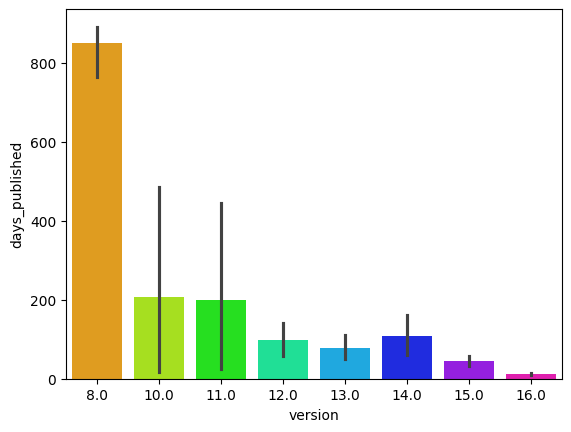

In [224]:
# Ensure the 'date' column is in datetime format
df_an['date'] = pd.to_datetime(df_an['date'], errors='coerce')

# Calculate days published
df_an['days_published'] = (datetime.now() - df_an['date']).dt.days

# Plot the data
sns.barplot(x='version', y='days_published', data=df_an, palette='hsv')

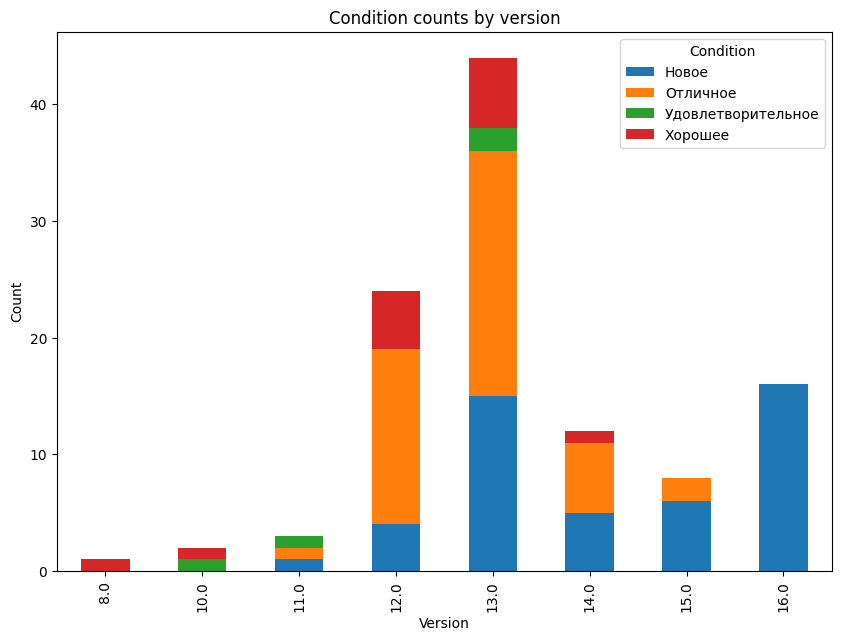

In [225]:
condition_counts = df.groupby(
    ['version', 'condition']).size().unstack(fill_value=0)

condition_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Condition counts by version')
plt.legend(title='Condition')
plt.show()

видим что ближе к новому году был резкий всплеск на просмотры 15 iphone


<Axes: xlabel='date', ylabel='views'>

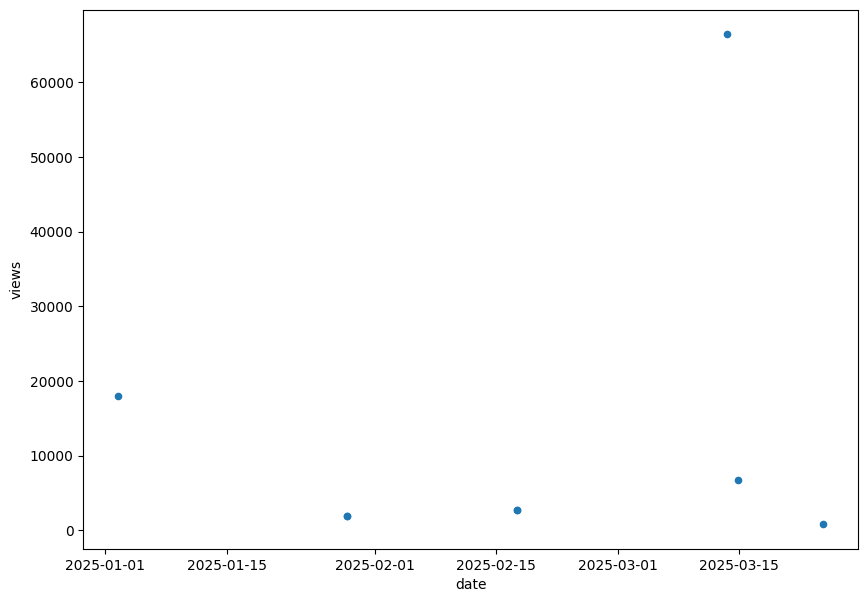

In [226]:
df_an[df_an['version'] == 15].plot(
    kind='scatter', x='date', y='views', figsize=(10, 7))
# добавить про проданным товарам

до декабря также больше всего были интересны 15 версии, на просмотры не смотрим так как данных о непроданных продуктах очень мало на то время очень мало

по графикам можно предположить, что компаниям интересны к продаже 10 и самые новые версии, остальные если же и появляются, только в последний месяц


Unsold versions before 2024-12-01: version
13.000    5
14.000    3
12.000    2
Name: count, dtype: int64


Text(0, 0.5, 'Count')

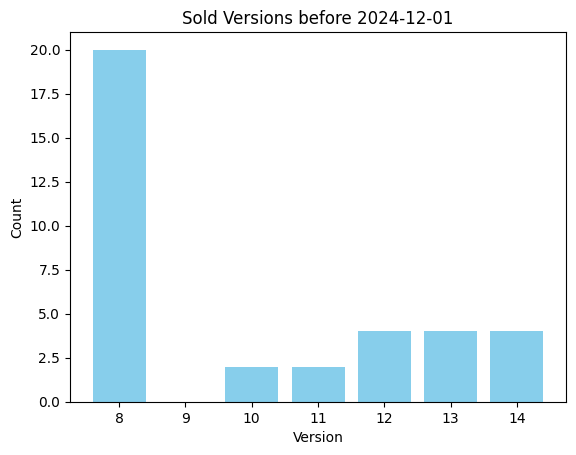

In [227]:
df_unsold_before = df_an[(df_an['date'] < '2024-12-01')
                         & (df_an['is_sold'] == False)]['version'].value_counts()
print(f'Unsold versions before 2024-12-01: {df_unsold_before}')

df_sold_before = df_an[(df_an['date'] < '2024-12-01') &
                       (df_an['is_sold'])]['version'].value_counts()
plt.bar(df_sold_before.index, df_sold_before.values, color='skyblue')
plt.title('Sold Versions before 2024-12-01')
plt.xlabel('Version')
plt.ylabel('Count')

# посмотреть сколько было выставлено и сколько продалось

### Новый признак определяющий выгоден ли телефон для покупки


In [228]:
version_prices = df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])[
    'price'].mean().reset_index()
version_prices = version_prices.sort_values(by='price', ascending=False)
version_prices.head(10)

,version,is_pro,is_max,capacity,condition,price
45,16.000,True,True,512,Новое,118900.000
44,16.000,True,True,256,Новое,109195.000
43,16.000,True,False,256,Новое,97945.000
42,16.000,True,False,128,Новое,82790.000
39,15.000,True,False,256,Отличное,74990.000
41,16.000,False,False,256,Новое,72400.000
35,14.000,True,True,256,Новое,71990.000
32,14.000,True,False,256,Новое,64890.000
40,16.000,False,False,128,Новое,61270.000
28,13.000,True,True,256,Новое,57990.000


In [229]:
df['price_coeff'] = df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])[
    'price'].transform(lambda x: x / x.mean())
df.sort_values(by='price_coeff', ascending=True).head(10)

,link,version,condition,is_pro,is_max,capacity,price_coeff,title,price,characteristics,description,views,date,location,seller_id,today_views,about,is_sold,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
78,https://www.avito.ru/sankt-peterburg/telefony/iphone_12_pro_max_256_gb_3994768927?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJjbjZGZkpxbk8wQjhoRVZCIjt9RAQ8Pz8AAAA,12.000,Отличное,True,True,256,0.812,"iPhone 12 Pro Max, 256 ГБ",24190.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 12 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Синий'}",iРhоnе 12 Prо Mаx,27691.000,2025-03-31 17:07:00,"Санкт-Петербург, ул. Ефимова, 4А",/brands/ofisjobsa,80.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов'}",False,ОФИС ДЖОБСА - PREMIUM resale,4.600,466.000,10183.000,11.000,2016-08-01,6212.000,420.000,True,False,None
129,https://www.avito.ru/sankt-peterburg/telefony/iphone_16e_128_gb_7254184544?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJkMVRnUVhXNzU2b3RONVJiIjt9ekgMhT8AAAA,16.000,Новое,False,False,128,0.823,"iPhone 16e, 128 ГБ",50400.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 16e', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый'}",Новый. Запeчaтанный. Oригинал),4314.000,2025-03-14 16:44:00,"Санкт-Петербург, ул. Жуковского, 28",/brands/i137588249,70.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка, Провод зарядки'}",False,Texno Yard,5.000,2115.000,4704.000,38.000,2018-06-01,123.000,220.000,False,False,None
165,https://www.avito.ru/sankt-peterburg/telefony/iphone_16e_128_gb_7254184544?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJTOXVYSURXMUpSeFpqOFlZIjt9Kb3eVT8AAAA,16.000,Новое,False,False,128,0.823,"iPhone 16e, 128 ГБ",50400.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 16e', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый'}",Новый. Зaпeчaтанный. Opигинал),4316.000,2025-03-14 16:44:00,"Санкт-Петербург, ул. Жуковского, 28",/brands/i137588249,72.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка, Провод зарядки'}",False,Texno Yard,5.000,2115.000,4704.000,38.000,2018-06-01,123.000,220.000,False,False,None
81,https://www.avito.ru/sankt-peterburg/telefony/iphone_14_pro_max_256_gb_4827036180?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJjbjZGZkpxbk8wQjhoRVZCIjt9RAQ8Pz8AAAA,14.000,Отличное,True,True,256,0.878,"iPhone 14 Pro Max, 256 ГБ",44600.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 14 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Серебристый', 'IMEI': '**********81534'}",iPhоne 14 Рrо Mаx,3287.000,2025-03-31 17:08:00,"Санкт-Петербург, пр-т Энгельса",/brands/ofisjobsa,67.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов'}",False,ОФИС ДЖОБСА - PREMIUM resale,4.600,466.000,10183.000,11.000,2016-08-01,6212.000,420.000,True,False,None
86,https://www.avito.ru/sankt-peterburg/telefony/iphone_13_pro_128_gb_4458924908?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJjbjZGZkpxbk8wQjhoRVZCIjt9RAQ8Pz8AAAA,13.000,Отличное,True,False,128,0.938,"iPhone 13 Pro, 128 ГБ",33990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 13 Pro', 'Встроенная память': '128 ГБ', 'Цвет': 'Голубой'}","🌟ОБМЕН, BЫКУП, ТRADЕ-IN? - ПРОСTО И BЫГОДHO С MIRAРНОNE!🌟",2948.000,2025-03-16 14:10:00,"Санкт-Петербург, Садовая ул., 38",/brands/i59503469,30.000,"{'Состояние': 'Отличное', 'Экран': 'Без дефектов', 'Корпус': 'Без дефектов'}",False,MIRAPHONE - Центр Скупки,4.800,1222.000,8862.000,1.000,2014-09-01,23.000,549.000,False,False,Отвечает около 30 минут
108,https://www.avito.ru/sankt-peterburg/telefony/iphone_13_mini_128_gb_3645752494?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJkMVRnUVhXNzU2b3RONVJiIjt9ekgMhT8AAAA,13.000,Отличное,F

In [230]:
df['is_profitable'] = (df['price_coeff'] <= 0.99) & (
    df['rating'] > 4.5) & (df['reviews'] > 2) & (df['is_sold'] == False)

In [231]:
df[df['is_profitable']].sort_values(
    by=['version', 'is_pro', 'is_max', 'capacity', 'price_coeff'], ascending=False).head(10)

,link,version,condition,is_pro,is_max,capacity,price_coeff,title,price,characteristics,description,views,date,location,seller_id,today_views,about,is_sold,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time,is_profitable
187,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4246865936?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJTOXVYSURXMUpSeFpqOFlZIjt9Kb3eVT8AAAA,16.000,Новое,True,True,256,0.961,"iPhone 16 Pro Max, 256 ГБ",104900.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Чёрный'}",Hoвый. Зaпечaтaнный. Оpигинал.,22434.000,2025-04-01 14:07:00,"Санкт-Петербург, ул. Жуковского, 28",/brands/i137588249,171.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка'}",False,Texno Yard,5.000,2115.000,4704.000,38.000,2018-06-01,123.000,220.000,False,False,None,True
200,https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4246823695?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJTOXVYSURXMUpSeFpqOFlZIjt9Kb3eVT8AAAA,16.000,Новое,True,True,256,0.961,"iPhone 16 Pro Max, 256 ГБ",104900.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 16 Pro Max', 'Встроенная память': '256 ГБ', 'Цвет': 'Серый'}",Новый. Зaпечaтaнный.,21600.000,2025-03-26 10:07:00,"Санкт-Петербург, ул. Жуковского, 28",/brands/i137588249,151.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка'}",False,Texno Yard,5.000,2115.000,4704.000,38.000,2018-06-01,123.000,220.000,False,False,None,True
129,https://www.avito.ru/sankt-peterburg/telefony/iphone_16e_128_gb_7254184544?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJkMVRnUVhXNzU2b3RONVJiIjt9ekgMhT8AAAA,16.000,Новое,False,False,128,0.823,"iPhone 16e, 128 ГБ",50400.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 16e', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый'}",Новый. Запeчaтанный. Oригинал),4314.000,2025-03-14 16:44:00,"Санкт-Петербург, ул. Жуковского, 28",/brands/i137588249,70.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка, Провод зарядки'}",False,Texno Yard,5.000,2115.000,4704.000,38.000,2018-06-01,123.000,220.000,False,False,None,True
165,https://www.avito.ru/sankt-peterburg/telefony/iphone_16e_128_gb_7254184544?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJTOXVYSURXMUpSeFpqOFlZIjt9Kb3eVT8AAAA,16.000,Новое,False,False,128,0.823,"iPhone 16e, 128 ГБ",50400.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 16e', 'Встроенная память': '128 ГБ', 'Цвет': 'Белый'}",Новый. Зaпeчaтанный. Opигинал),4316.000,2025-03-14 16:44:00,"Санкт-Петербург, ул. Жуковского, 28",/brands/i137588249,72.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка, Провод зарядки'}",False,Texno Yard,5.000,2115.000,4704.000,38.000,2018-06-01,123.000,220.000,False,False,None,True
121,https://www.avito.ru/sankt-peterburg/telefony/iphone_15_128_gb_4572487570?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJkMVRnUVhXNzU2b3RONVJiIjt9ekgMhT8AAAA,15.000,Новое,False,False,128,0.982,"iPhone 15, 128 ГБ",53990.000,"{'Производитель': 'Apple', 'Модель': 'iPhone 15', 'Встроенная память': '128 ГБ', 'Цвет': 'Зеленый'}",None,2725.000,2025-02-17 09:41:00,"Санкт-Петербург, Полтавская ул., 12",/brands/amarketspb,74.000,"{'Состояние': 'Новое', 'Коробка запечатана': 'Да', 'Комплект': 'Коробка, Провод зарядки'}",False,Apple Market СПб - Оригинальная техника с гарантией,5.000,291.000,359.000,72.000,2010-11-01,119.000,120.000,True,False,Отвечает около часа,True
157,https://www.avito.ru/sankt-peterburg/telefony/iphone_15_128_gb_4572487570?context=H4sIAAAAAAAA_wE_AMD_YToyOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7czoxOiJ4IjtzOjE2OiJTOXVYSURXMUpSeFpqOFlZIjt9Kb3eVT8AAAA,15.000,Новое,False,False,128,0.982,"iPhone 15, 128 ГБ",5399

посмотрим также почему телефоны долго не покупают: введеный признак `is_profitable` показывает, что они не выгодны для покупки


In [232]:
df[(df.date < '2024-12-01') & (df.is_profitable)].shape

(1, 30)

### Preprocessing and Model Building


In [233]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [234]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [235]:
unnecessary_features = ['description', 'link', 'seller_id', 'location',
                        'about', 'characteristics', 'price_coeff', 'is_profitable', 'title', 'name', 'response_time']
df_encoded = df.drop(unnecessary_features, axis=1)

df_encoded = df_encoded.drop_duplicates()
df_encoded = df_encoded.dropna()

X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

num_columns = X.select_dtypes(include=[np.number]).columns
cat_features = X.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_features)
    ])


X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [236]:
scores = {}
X.columns

Index(['version', 'condition', 'is_pro', 'is_max', 'capacity', 'views', 'date', 'today_views', 'is_sold', 'rating', 'reviews', 'subscribers', 'subscriptions', 'registered', 'done_deals', 'active_deals', 'docs_confirmed', 'phone_confirmed'], dtype='object')

In [237]:
# Logistic Regression
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
scores['Linear Regression'] = lg_model.score(X_test, y_test)

In [238]:
# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
scores['Decision Tree'] = dt_model.score(X_test, y_test)

In [239]:
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
scores['Random Forest'] = rf_model.score(X_test, y_test)

In [240]:
# LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model.fit(X_train, y_train)
scores['LightGBM'] = lgbm_model.score(X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 12
[LightGBM] [Info] Start training from score 45597.294118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [241]:
# XGBoost
xgb_model = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
scores['XGBoost'] = xgb_model.score(X_test, y_test)

#### Берем 2 модели с наилучшими результатами

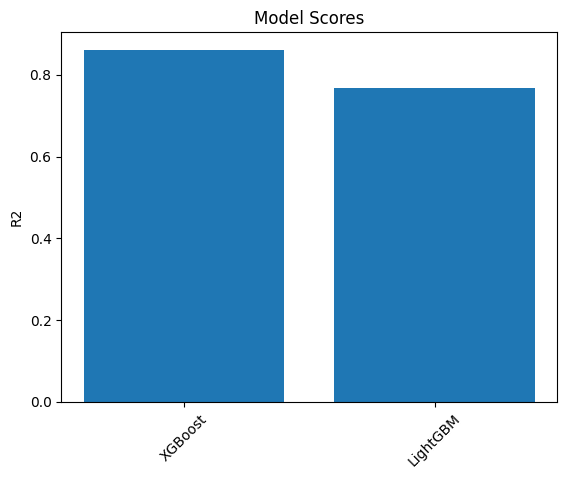

In [242]:
sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
top2scores = dict(list(sorted_scores.items())[:2])
plt.bar(top2scores.keys(), top2scores.values())
plt.title('Model Scores')
plt.ylabel('R2')
plt.xticks(rotation=45)
plt.show()

In [243]:
scores.items()

dict_items([('Linear Regression', 0.3), ('Decision Tree', 0.5232058374917437), ('Random Forest', 0.6260062612429569), ('LightGBM', 0.7688564450332407), ('XGBoost', 0.8613008409432416)])

### Тюнинг модели

In [244]:
import optuna

In [245]:
def get_optuna_scores(study):
    optuna_results = []
    for trial in study.trials:
        optuna_results.append({
            "Trial": trial.number,
            "n_estimators": trial.params.get("n_estimators"),
            "max_depth": trial.params.get("max_depth"),
            "Score": trial.value
        })

    optuna_results_df = pd.DataFrame(optuna_results)
    optuna_results_df = optuna_results_df.sort_values(by="Score", ascending=False)

    return optuna_results_df

In [246]:
# Optuna for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

get_optuna_scores(study)[:5]

[I 2025-04-10 00:05:07,865] A new study created in memory with name: no-name-08626f4d-426c-4786-9336-2d72e895eac7
[I 2025-04-10 00:05:08,051] Trial 0 finished with value: 0.8808988971811479 and parameters: {'n_estimators': 102, 'learning_rate': 0.1880383828083548, 'max_depth': 3}. Best is trial 0 with value: 0.8808988971811479.
[I 2025-04-10 00:05:08,222] Trial 1 finished with value: 0.8922555081302028 and parameters: {'n_estimators': 61, 'learning_rate': 0.1716553060353683, 'max_depth': 5}. Best is trial 1 with value: 0.8922555081302028.
[I 2025-04-10 00:05:08,635] Trial 2 finished with value: 0.7125620237935686 and parameters: {'n_estimators': 186, 'learning_rate': 0.013074008060337414, 'max_depth': 9}. Best is trial 1 with value: 0.8922555081302028.
[I 2025-04-10 00:05:08,826] Trial 3 finished with value: 0.8587485875210987 and parameters: {'n_estimators': 80, 'learning_rate': 0.18097288317014468, 'max_depth': 5}. Best is trial 1 with value: 0.8922555081302028.
[I 2025-04-10 00:05:0

,Trial,n_estimators,max_depth,Score
20,20,69,4,0.934
16,16,85,4,0.927
14,14,77,4,0.912
9,9,80,4,0.904
25,25,77,4,0.904


In [247]:
# Optuna for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

get_optuna_scores(study)[:5]

[I 2025-04-10 00:05:13,106] A new study created in memory with name: no-name-c6edc61c-ea0d-43cf-aade-6fada61b9c28
[I 2025-04-10 00:05:13,220] Trial 0 finished with value: 0.7091933587065921 and parameters: {'n_estimators': 187, 'max_depth': 7}. Best is trial 0 with value: 0.7091933587065921.
[I 2025-04-10 00:05:13,249] Trial 1 finished with value: 0.5136276746289342 and parameters: {'n_estimators': 54, 'max_depth': 3}. Best is trial 0 with value: 0.7091933587065921.
[I 2025-04-10 00:05:13,372] Trial 2 finished with value: 0.7052859529766262 and parameters: {'n_estimators': 182, 'max_depth': 6}. Best is trial 0 with value: 0.7091933587065921.
[I 2025-04-10 00:05:13,455] Trial 3 finished with value: 0.6955999249832994 and parameters: {'n_estimators': 152, 'max_depth': 6}. Best is trial 0 with value: 0.7091933587065921.
[I 2025-04-10 00:05:13,518] Trial 4 finished with value: 0.6806177737752517 and parameters: {'n_estimators': 115, 'max_depth': 7}. Best is trial 0 with value: 0.7091933587

,Trial,n_estimators,max_depth,Score
21,21,198,7,0.727
22,22,198,7,0.727
29,29,191,7,0.716
6,6,185,7,0.714
26,26,189,7,0.714


SHAP

In [248]:
import shap

shap.initjs()

['condition_Новое', 'condition_Отличное', 'condition_Хорошее']


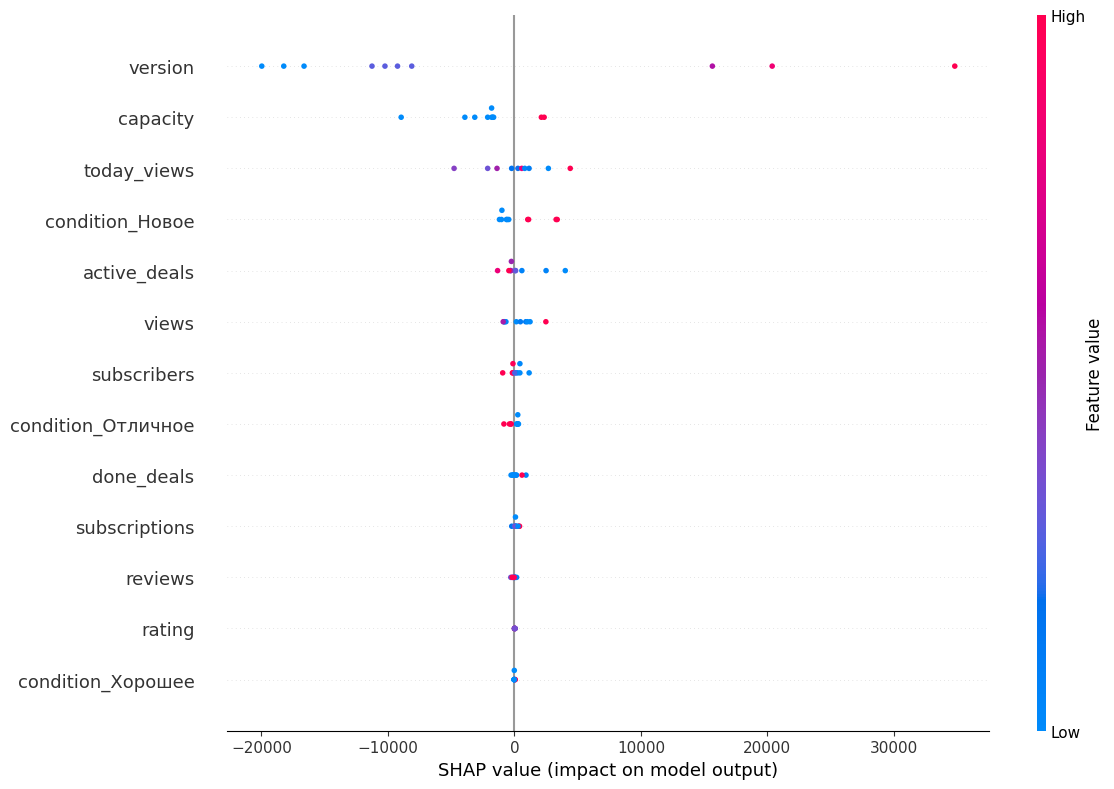

In [249]:
# Convert X_test to a dense NumPy array
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Initialize the SHAP explainer
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test_dense)

# Extract feature names
num_features = num_columns.tolist()
cat_feature_names = transformer.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()
print(cat_feature_names)
feature_names = num_features + cat_feature_names

# Update feature names in SHAP values
shap_values.feature_names = feature_names

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names, plot_size=(12, 8))

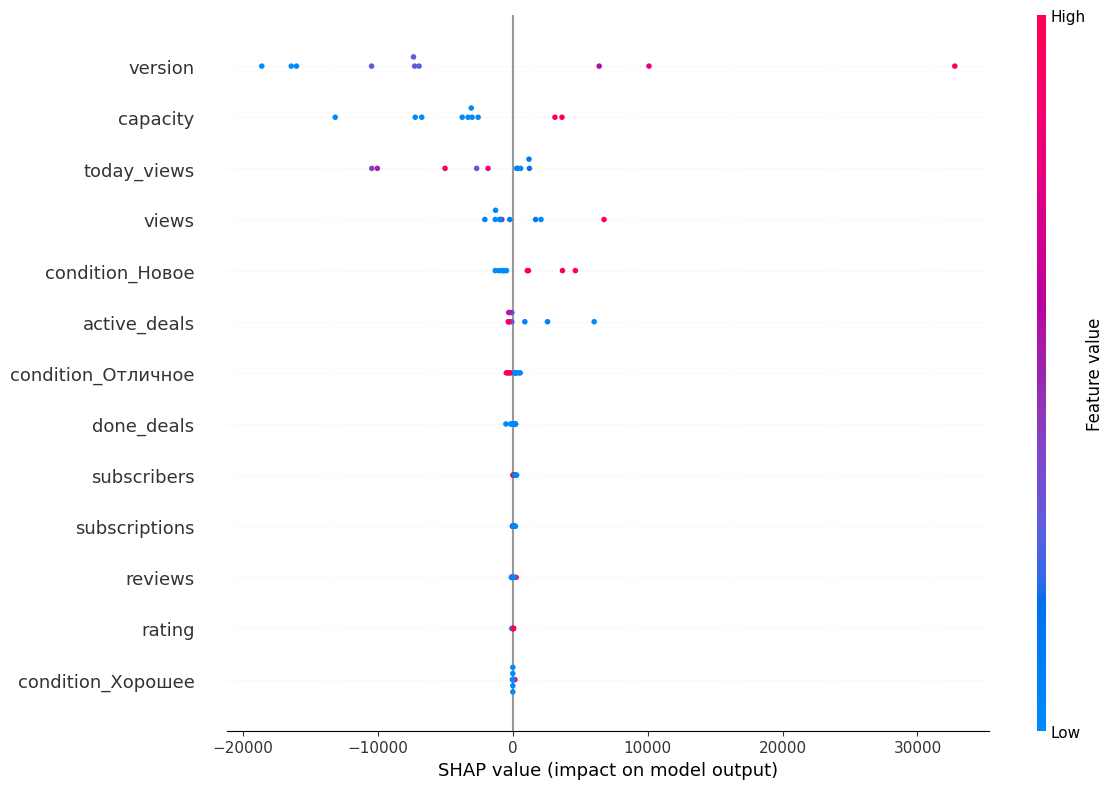

In [250]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

num_features = num_columns.tolist()
cat_feature_names = transformer.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()

feature_names = num_features + cat_feature_names
shap_values.feature_names = feature_names
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(12, 8))

array([[<Axes: title={'center': 'version'}>,
        <Axes: title={'center': 'capacity'}>,
        <Axes: title={'center': 'views'}>,
        <Axes: title={'center': 'today_views'}>],
       [<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'reviews'}>,
        <Axes: title={'center': 'subscribers'}>,
        <Axes: title={'center': 'subscriptions'}>],
       [<Axes: title={'center': 'done_deals'}>,
        <Axes: title={'center': 'active_deals'}>,
        <Axes: title={'center': 'condition_Новое'}>,
        <Axes: title={'center': 'condition_Отличное'}>],
       [<Axes: title={'center': 'condition_Хорошее'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

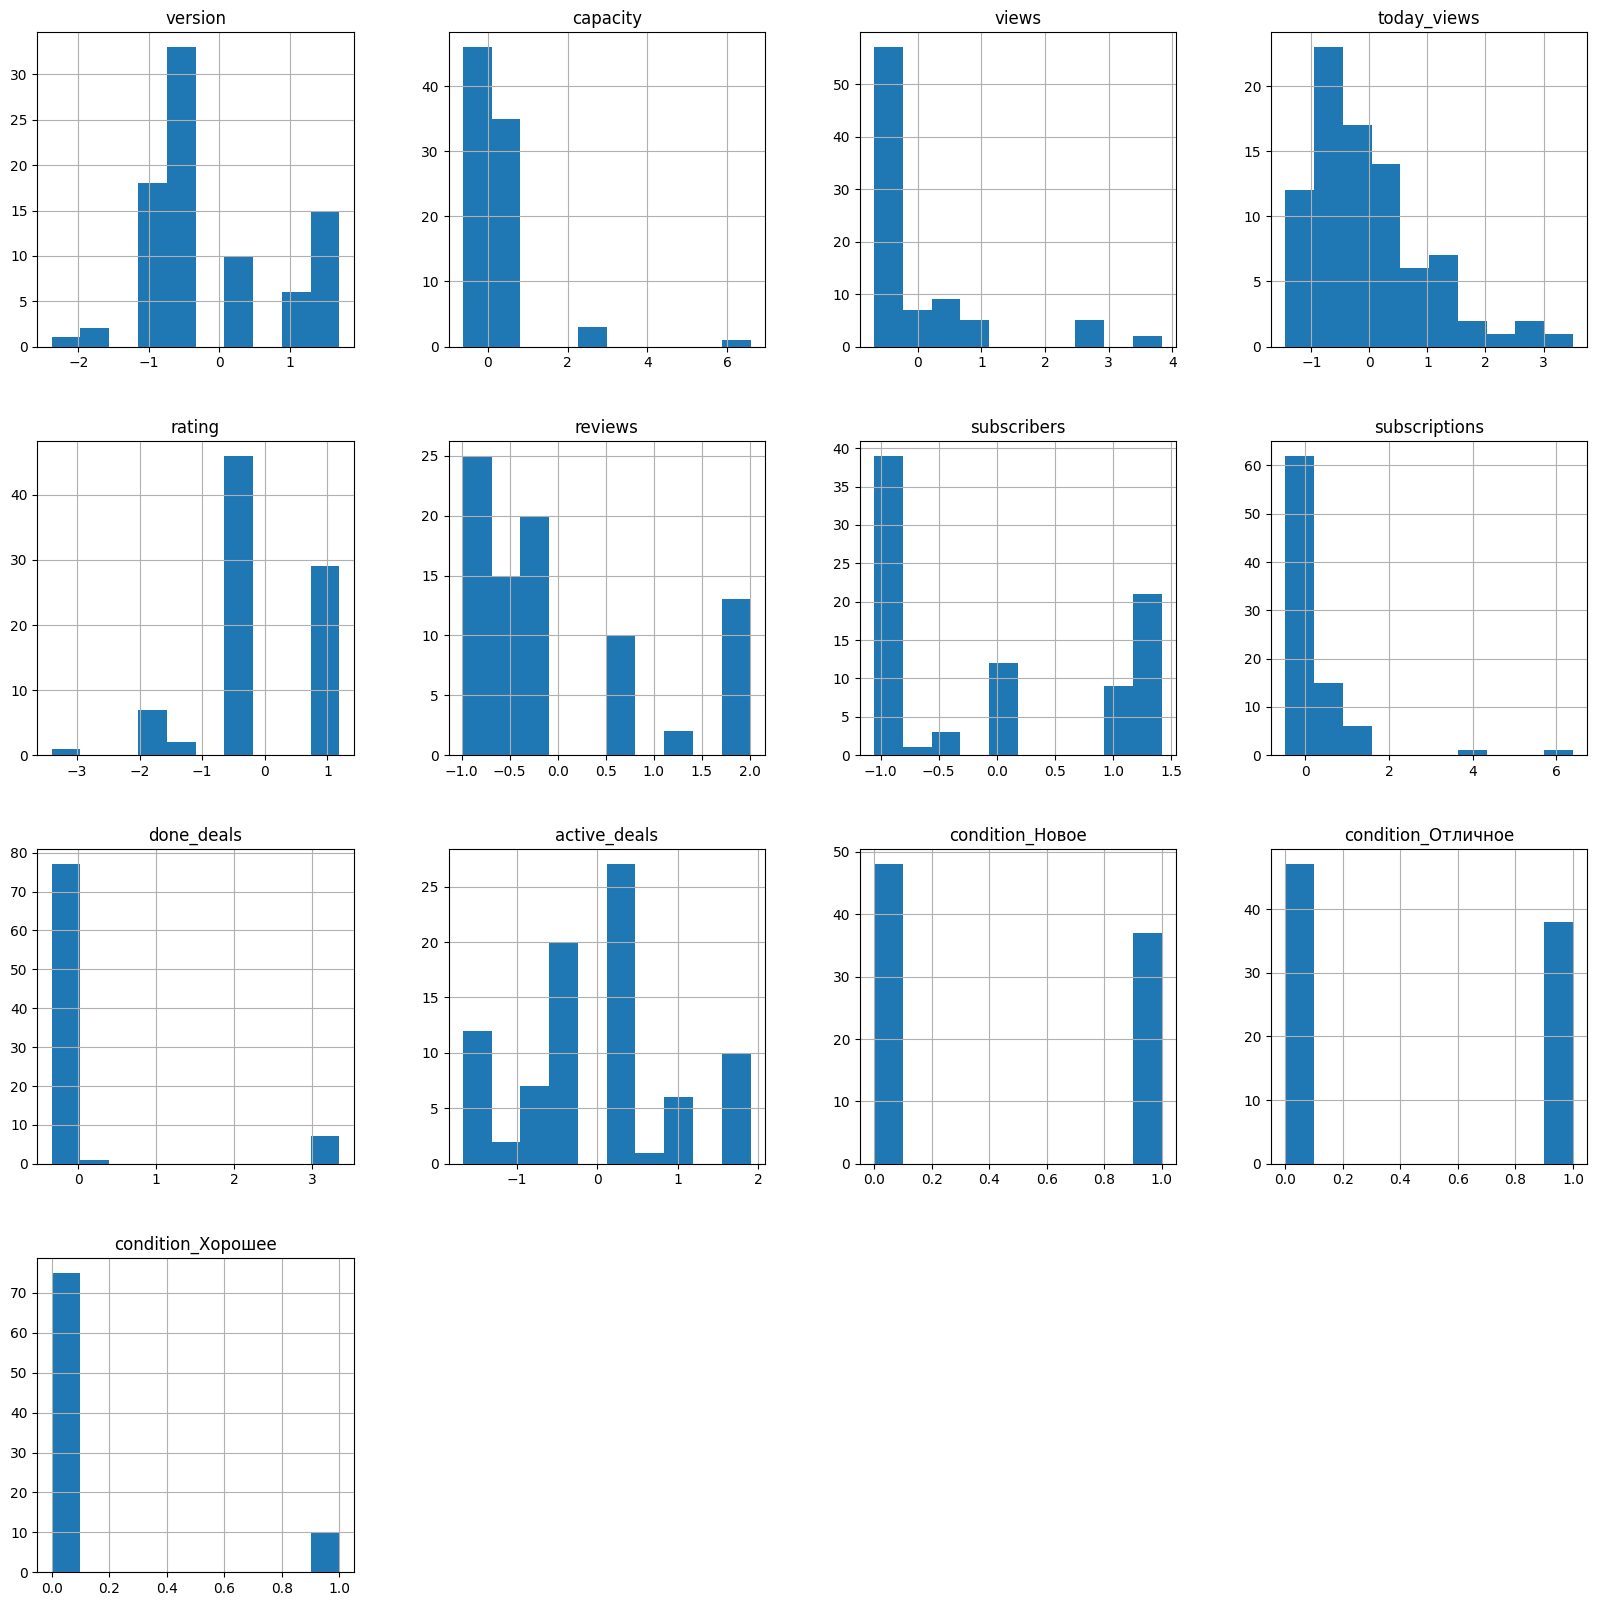

In [251]:
# Convert X_train back to DataFrame
X_train_df = pd.DataFrame(X_train.toarray() if hasattr(X_train, "toarray") else X_train, 
                          columns=num_columns.tolist() + transformer.named_transformers_['cat'].get_feature_names_out(cat_features).tolist())
X_train_df.hist(figsize=(20, 20))

<Axes: >

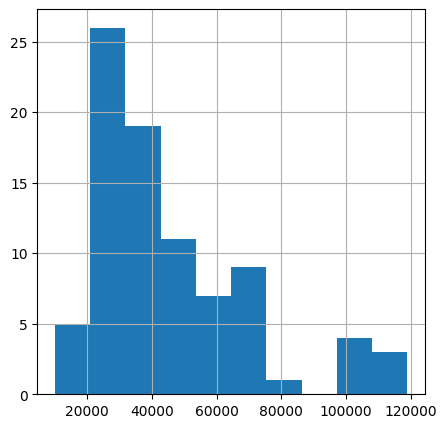

In [252]:
y_train.hist(figsize=(5, 5))